In [12]:
# required imports
%matplotlib inline
import numpy as np
import pandas as pd
import math
import pdb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(21)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(21)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# load data
all_games = pd.read_csv('..\Web_Scrapping_Experiments\static\data/all_Games.csv')

will use StandardScaler for the features, and MinMaxScaler (to scale values between 0 and 1) for the output values

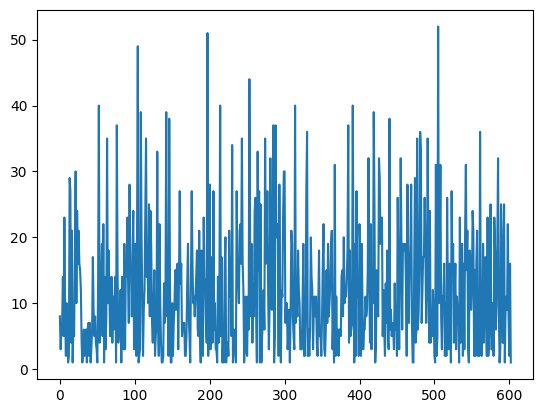

In [8]:
training_set = all_games[['Ball_1']].values.astype('float32')
test_set = all_games[['Ball_1']].values.astype('float32')

batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(training_set) / batch_size)
num_epochs = int(num_epochs)

plt.plot(training_set, label = 'Shampoo Sales Data')
plt.show()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=training_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [4]:
class LSTMCell(nn.Module):

    """
    An implementation of Hochreiter & Schmidhuber:
    'Long-Short Term Memory' cell.
    http://www.bioinf.jku.at/publications/older/2604.pdf

    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.c2c = Tensor(hidden_size * 3)
        self.reset_parameters()



    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        #pdb.set_trace()
        hx, cx = hidden
        
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
    
        gates = gates.squeeze()
        
        c2c = self.c2c.unsqueeze(0)
        ci, cf, co = c2c.chunk(3,1)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = torch.sigmoid(ingate+ ci * cx)
        forgetgate = torch.sigmoid(forgetgate + cf * cx)
        cellgate = forgetgate*cx + ingate* torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate+ co*cellgate)
        

        hm = outgate * F.tanh(cellgate)
        return (hm, cellgate)

In [5]:
'''
STEP 3: CREATE MODEL CLASS
'''
 
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
               
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)  
        
        self.fc = nn.Linear(hidden_dim, output_dim)
     
    
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = Tensor(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Tensor(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        # Initialize cell state
        if torch.cuda.is_available():
            c0 = Tensor(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Tensor(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

                    
       
        outs = []
        
        cn = c0[0,:,:]
        hn = h0[0,:,:]
        
        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn,cn)) 
            outs.append(hn)
            
    

        out = outs[-1].squeeze()
        
        out = self.fc(out) 
        # out.size() --> 100, 10
        return out

In [6]:
'''
STEP 4: INSTANTIATE MODEL CLASS
'''
input_dim = 28
hidden_dim = 128
layer_dim = 1  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 10
 
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
#model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################
 
if torch.cuda.is_available():
    model.cuda()
     
'''
STEP 5: INSTANTIATE LOSS CLASS
'''
criterion = nn.CrossEntropyLoss()
 
'''
STEP 6: INSTANTIATE OPTIMIZER CLASS
'''
learning_rate = 0.1
 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [9]:
'''
STEP 7: TRAIN THE MODEL
'''
 
# Number of steps to unroll
seq_dim = 28 

loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
          
        if torch.cuda.is_available():
            images = images.view(-1, seq_dim, input_dim).cuda()
            labels = labels.cuda()
        else:
            images = images.view(-1, seq_dim, input_dim)
            labels = labels
          
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        
        loss_list.append(loss.item())
        iter += 1
         
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    images = images.view(-1, seq_dim, input_dim).cuda()
                else:
                    images = images.view(-1 , seq_dim, input_dim)
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                 
                # Total number of labels
                total += labels.size(0)
                 
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
             
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

NameError: name 'train_loader' is not defined